In [1]:
# Regression Example - proof of concept, values are wrong!!!!
import pandas as pd
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from tensorflow.keras.backend import clear_session

Using TensorFlow backend.


In [2]:
clear_session() #borra el grafo de la sesion. Util cuando creamos muchos modelos en una sesion.

# load dataset
n_epochs = 5000

# Read datasets and remove NAs
na_values = ['NaN', 'NA', 'na', 'nan']

fp = pd.read_csv('datasets/CYP2C9_fingerprints.csv', header=None, na_values=na_values)
target = pd.read_csv('datasets/tsne_CYP2C9_fingerprints.csv').iloc[:,2:4]

index_null_data = fp[fp.isnull().any(axis=1)].index
fp.drop(index_null_data, inplace=True)

fp_train = fp.iloc[:10000,1:].values
fp_test = fp.iloc[10000:11000,1:].values
fp_valid = fp.iloc[11000:,1:].values

In [3]:
callbk1 = EarlyStopping(monitor='val_loss', 
                       mode='min',
                       patience=50,
                       #restore_best_weights=True,
                       verbose=True)

In [4]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=1024, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [9]:
scaler = StandardScaler()
new_target= scaler.fit_transform(target.values)

t_train = new_target[:10000,:]
t_test = new_target[10000:11000,:]
t_valid = new_target[11000:,:]

In [10]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=500, batch_size=100, verbose=2)
estimator.fit(fp_train, t_train, validation_data=[fp_test, t_test], callbacks=[callbk1])

Train on 10000 samples, validate on 1000 samples
Epoch 1/500
 - 1s - loss: 0.7380 - val_loss: 0.5311
Epoch 2/500
 - 0s - loss: 0.4388 - val_loss: 0.4404
Epoch 3/500
 - 0s - loss: 0.3676 - val_loss: 0.3979
Epoch 4/500
 - 0s - loss: 0.3156 - val_loss: 0.3902
Epoch 5/500
 - 0s - loss: 0.2653 - val_loss: 0.3367
Epoch 6/500
 - 0s - loss: 0.2218 - val_loss: 0.3020
Epoch 7/500
 - 0s - loss: 0.1808 - val_loss: 0.2879
Epoch 8/500
 - 0s - loss: 0.1495 - val_loss: 0.2835
Epoch 9/500
 - 0s - loss: 0.1211 - val_loss: 0.2857
Epoch 10/500
 - 0s - loss: 0.0982 - val_loss: 0.2733
Epoch 11/500
 - 0s - loss: 0.0799 - val_loss: 0.2724
Epoch 12/500
 - 0s - loss: 0.0645 - val_loss: 0.2750
Epoch 13/500
 - 0s - loss: 0.0525 - val_loss: 0.2755
Epoch 14/500
 - 0s - loss: 0.0424 - val_loss: 0.2685
Epoch 15/500
 - 0s - loss: 0.0341 - val_loss: 0.2728
Epoch 16/500
 - 0s - loss: 0.0281 - val_loss: 0.2663
Epoch 17/500
 - 0s - loss: 0.0238 - val_loss: 0.2706
Epoch 18/500
 - 0s - loss: 0.0197 - val_loss: 0.2682
Epoch 

## Model prediction

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Train

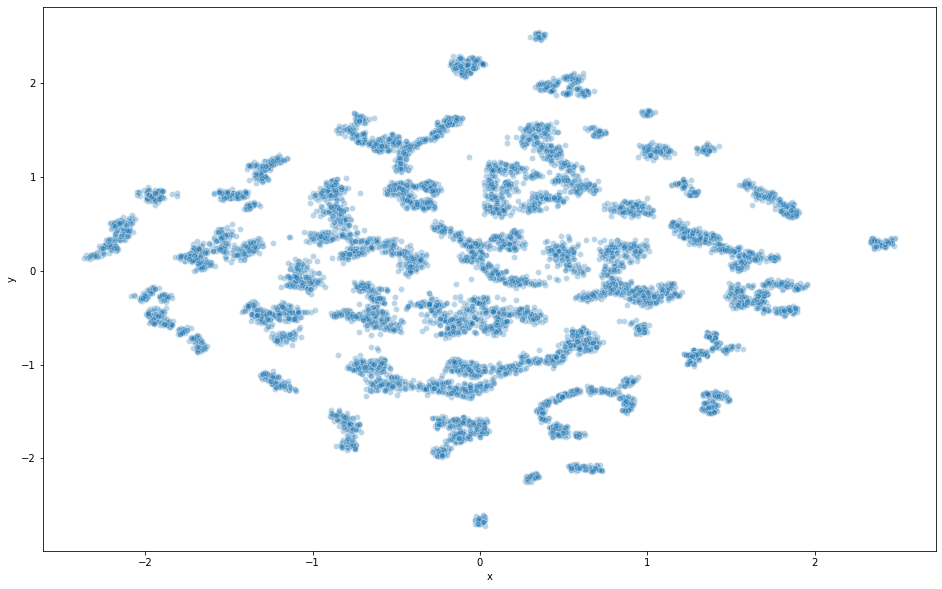

In [12]:
# Formatting for scatterplot: run only on jupyter notebooks
pred = estimator.predict(fp_train)
data = pd.DataFrame(pred, index = np.arange(len(pred)),columns=['x','y'])

plt.figure(figsize=(16,10))
sns.scatterplot(x="x", y="y", data= data, legend="full", alpha=0.3)

### Test

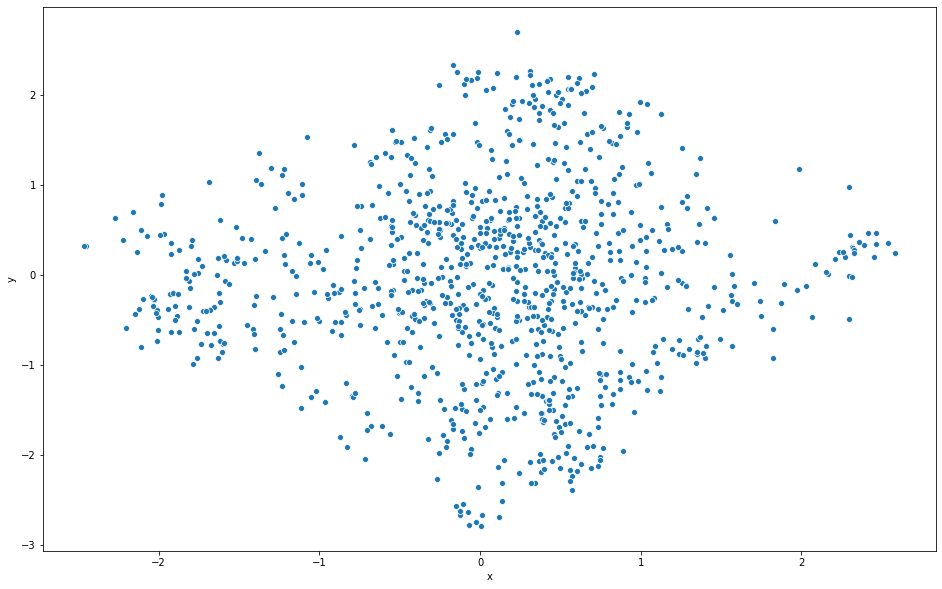

In [13]:
# Formatting for scatterplot: run only on jupyter notebooks
pred = estimator.predict(fp_test)
data = pd.DataFrame(pred, index = np.arange(len(pred)),columns=['x','y'])

plt.figure(figsize=(16,10))
sns.scatterplot(x="x", y="y", data= data, legend="full", alpha=1)

## Actual tsne projection

### Train

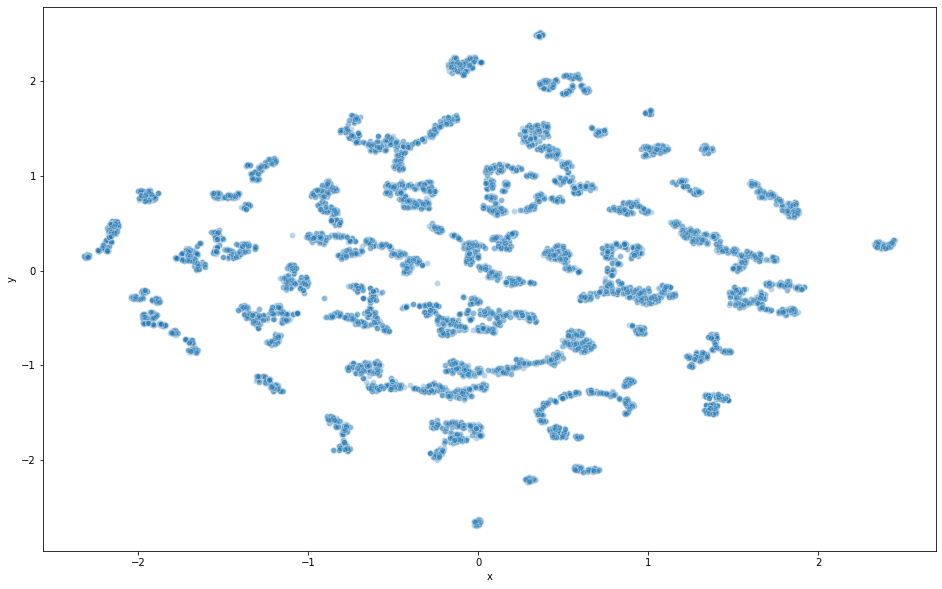

In [14]:
# Formatting for scatterplot: run only on jupyter notebooks
data = pd.DataFrame(t_train, index = np.arange(len(t_train)),columns=['x','y'])

plt.figure(figsize=(16,10))
sns.scatterplot(x="x", y="y", data= data, legend="full", alpha=0.3)

### Test

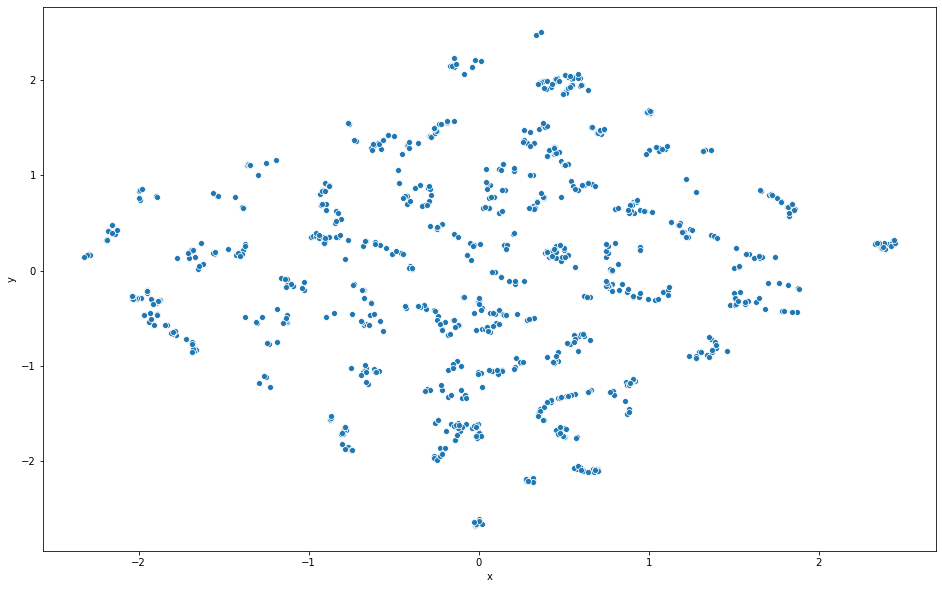

In [15]:
# Formatting for scatterplot: run only on jupyter notebooks
data = pd.DataFrame(t_test, index = np.arange(len(t_test)),columns=['x','y'])

plt.figure(figsize=(16,10))
sns.scatterplot(x="x", y="y", data= data, legend="full", alpha=1)

In [23]:
plot_1 = np.array([pred[:,0],t_test[:,0]])
plot_1 = plot_1.T

plot_2 = np.array([pred[:,1],t_test[:,1]])
plot_2 = plot_2.T

plot_1.shape

(1000, 2)

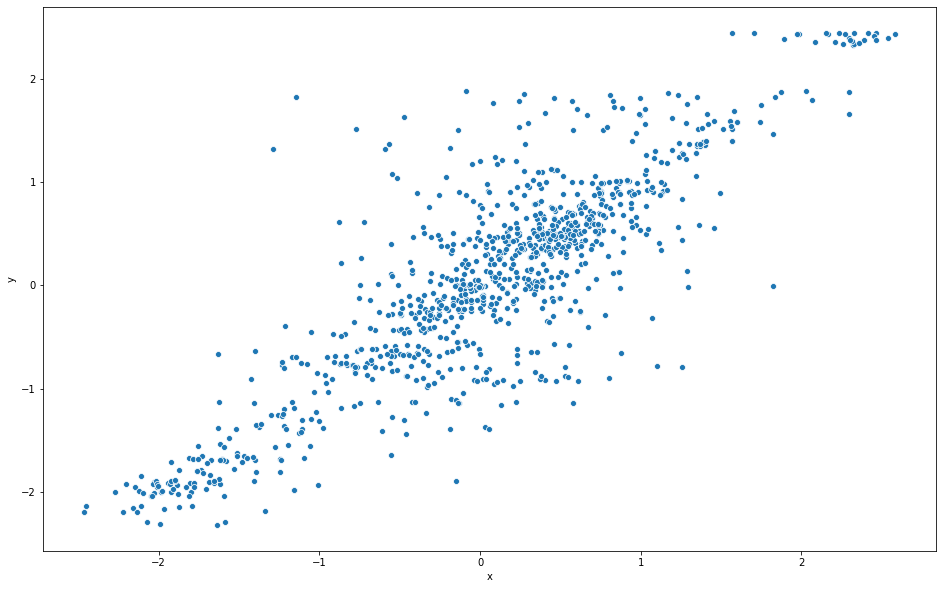

In [24]:
# Formatting for scatterplot: run only on jupyter notebooks
data = pd.DataFrame(plot_1, index = np.arange(len(plot_1)),columns=['x','y'])

plt.figure(figsize=(16,10))
sns.scatterplot(x="x", y="y", data= data, legend="full", alpha=1)

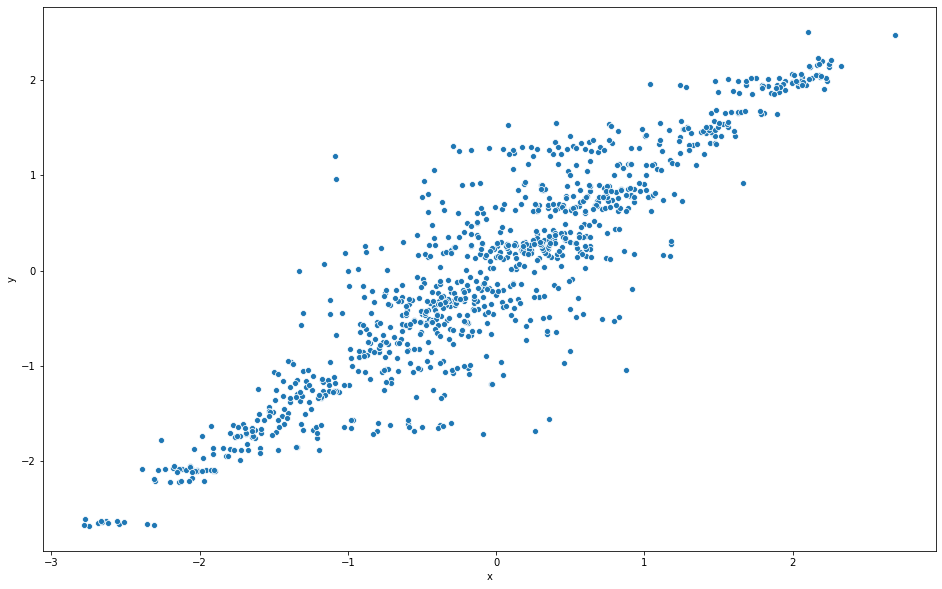

In [25]:
# Formatting for scatterplot: run only on jupyter notebooks
data = pd.DataFrame(plot_2, index = np.arange(len(plot_2)),columns=['x','y'])

plt.figure(figsize=(16,10))
sns.scatterplot(x="x", y="y", data= data, legend="full", alpha=1)

In [26]:
import scipy
scipy.stats.pearsonr(plot_1[:,0], plot_1[:,1])

(0.8610214772011809, 2.5347770185586455e-295)

In [64]:
# serialize model to JSON
model_json = estimator.model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
estimator.model.save_weights("model.h5")